# Modello convolutivo di base
In questo notebook costruiamo un **modello convolutivo di base** così da poter avere un'idea migliore del task che stiamo approcciando. Utilizzando un modello di base riusciamo a capire soprattutto che prestazioni riusciamo a ottenere senza troppi sforzi.

In [ ]:
!pip install tensorflow_io

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio', 
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True, 
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [3]:
for audios, labels in train_ds:
    print("Forma (shape) audio:", audios.shape)
    print("Forma (shape) classi:", labels.shape)
    break

Forma (shape) audio: (32, 16000, 1)
Forma (shape) classi: (32,)


Possiamo notare che lo shape dell'audio corrisponde a (32, 16000, 1), questo vuol dire che ogni "audio" che stiamo stampando in realtà è un batch da 32 tensori di lunghezza 16000 unidimensionali. Ovviamente anche lo shape delle classi sarà 32 visto e considerata la presenza di 32 tensori per iterazione. Abbiamo perciò capito che il nostro dataset è suddiviso in batch da 32 di grandezza, questo perché di default la funzione `tf.keras.utils.audio_dataset_from_directory(directory)` ha il parametro `batch_size` impostato a 32 (non avendo specificato la grandezza del batch_size è stato quindi utilizzato automaticamente 32).

## Funzioni per processamento dei dati

Il prossimo step è definire la funzione `squeeze(audio, labels)`, che come è possibile notare prende in input l'audio e le classi, e serve per applicare la funzione `tf.squeeze` ai file che scegliamo di passargli. Abbiamo utilizzato alcune volte la funzione `tf.squeeze` a lezione, ma non ci siamo mai soffermati su di essa.

In [4]:
def squeeze(audio, labels): 
    audio = tf.squeeze(audio, axis=-1) 
    return audio, labels 

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Questo passaggio di squeeze ci serve a rimuovere l'ultima asse dello shape dei nostri audio. Noi attualmente abbiamo uno shape di (32, 16000, 1), dove quel 1 finale è in realtà inutile. Quindi specificando in `tf.squeeze` il parametro **axis=-1** stiamo dicendo di rimuovere l'ultima dimensione, trasformando la forma del nostro audio in (32, 16000).

Quella dimensione finale risulta attualmente inutile, quindi stiamo semplificando la forma del nostro audio e allo stesso tempo anche rendendo un minimo più efficiente il processamento dei dati stessi.

In [5]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE) 
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


Adesso che abbiamo semplificato la forma (shape) dei nostri audio possiamo procedere col trasformarli in spettrogrammi. Il nostro obbiettivo è utilizzare un modello convolutivo, che come sappiamo prende in input delle immagini. Noi attualmente abbiamo ancora dei tensori di audio, e non delle immagini, perciò dobbiamo convertire il nostro dataset.

## Conversione e suddivisione dataset
Andremo ad utilizzare due funzioni: `get_spectrogram` e `get_spectrogram_dataset`. Queste due funzioni usate insieme ci ritornano un dataset di spettrogrammi. La prima funzione `get_spectrogram` converte il singolo audio in spettrogramma mentre la seconda funzione `get_spectrogram_dataset` richiama la prima funzione per ogni dato presente nel dataset.

In [6]:
def get_spectrogram(waveform): 
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram) 
    
    return spectrogram[..., tf.newaxis] 

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [7]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Definite le due funzioni possiamo procedere a ottenere il nostro training set, validation set, e test set di spettrogrammi. La suddivisione di dati ricordo essere rispettivamente 60%, 20%, 20%.

In [8]:
train_ds = get_spectrogram_dataset(train_ds)
validation_ds = get_spectrogram_dataset(validation_ds)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

In [9]:
print("Numero di audio training set:", len(train_ds) * 32)
print("Numero di audio validation set:", len(val_ds) * 32)
print("Numero di audio test set:", len(test_ds) * 32)

Numero di audio training set: 7776
Numero di audio validation set: 2592
Numero di audio test set: 2592


Shape (forma) spettrogrammi: (32, 124, 129, 1)


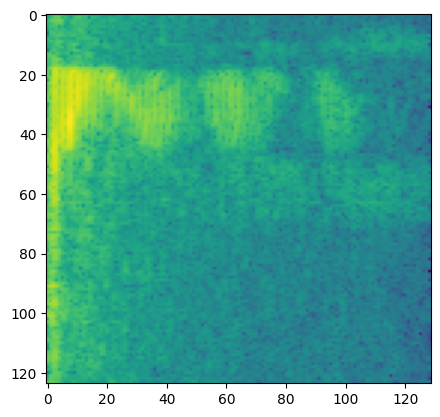

In [16]:
for audio, label in train_ds:
    print("Shape (forma) spettrogrammi:", audio.shape)
    plt.imshow(np.log(audio[0]))
    break

La grandezza dei nostri spettrogrammi, e quindi delle nostre immagini, è di **124x129**.

## Creazione modello di base

In [61]:
def get_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Resizing(120, 120)(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)

    # Livelli per l'apprendimento della rappresentazione delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    
    # Livelli per la classificazione
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)
    
    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [62]:
model = get_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 124, 129, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 120, 120, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_16 (Rescaling)             │ (None, 120, 120, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 118, 118, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_60 (MaxPooling2D)      │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_61 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_78 (Conv2D)                   │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_62 (MaxPooling2D)      │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_79 (Conv2D)                   │ (None, 11, 11, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 30)                  │          69,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,047,070 (3.99 MB)

 Trainable params: 1,047,070 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/convnet_from_scratch.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.0359 - loss: 3.3978 - val_accuracy: 0.0285 - val_loss: 3.3936
Epoch 2/30
175/243 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0390 - loss: 3.3926